In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

# 1. Index Price Forecast

### A. Import data into python development environment as a Data Frame variable called data_df_raw 

In [2]:
#data_df_raw = pd.read_excel("/Users/yijunshen/Question_DataSet.xlsx - US3387.csv", index_col = 0)
data_df_raw = pd.read_excel("/Users/yijunshen/Question_DataSet.xlsx", index_col = 0)
data_df_raw.info()
data_df_raw.head()

<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, 2007-04-30 00:00:00 to 2022-11-30 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   US3387   185 non-null    float64
dtypes: float64(1)
memory usage: 2.9+ KB


,US3387
Date,
2007-04-30 00:00:00,16.270665
2007-05-31 00:00:00,16.565997
2007-06-30 00:00:00,16.483031
2007-07-31 00:00:00,16.662449
2007-08-31 00:00:00,16.763681


### B. Convert the date column into datetime format and set them as the DataFrame index. Perform any necessary data cleaning/preprocessing. Write comments and/or any assumptions (if used) at the front of each preprocessing step taken.

In [3]:
data_df_raw.index = pd.to_datetime(data_df_raw.index, errors='coerce')#convert the date column into datetime format

In [4]:
data_df_raw.fillna(data_df_raw.shift(1))#fill the na value with previous month's return
df_return = data_df_raw.pct_change().dropna()#conduct the daily return to check the patter of the price

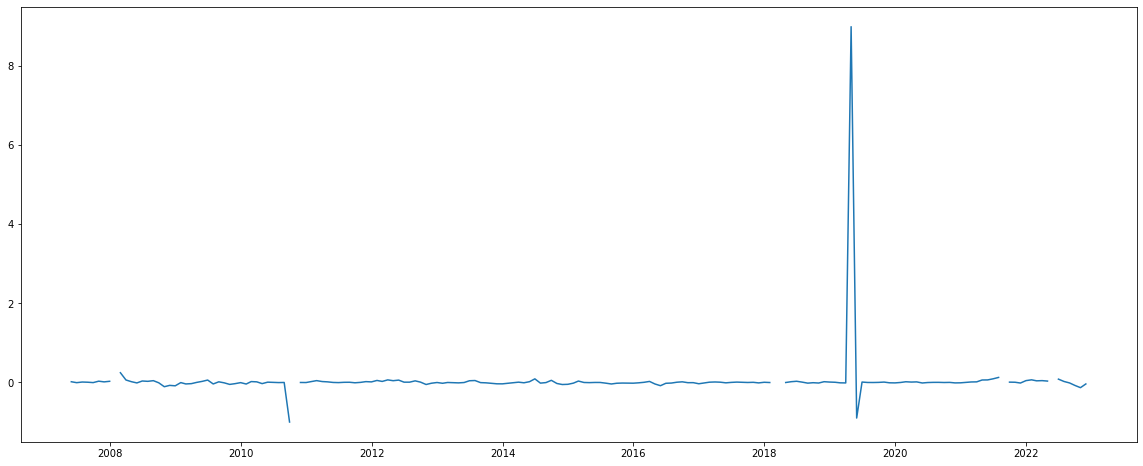

In [5]:
fig = plt.figure(figsize=(20,8))
plt.plot(df_return)#from the graph, we can tell that the daily return is pretty stable 

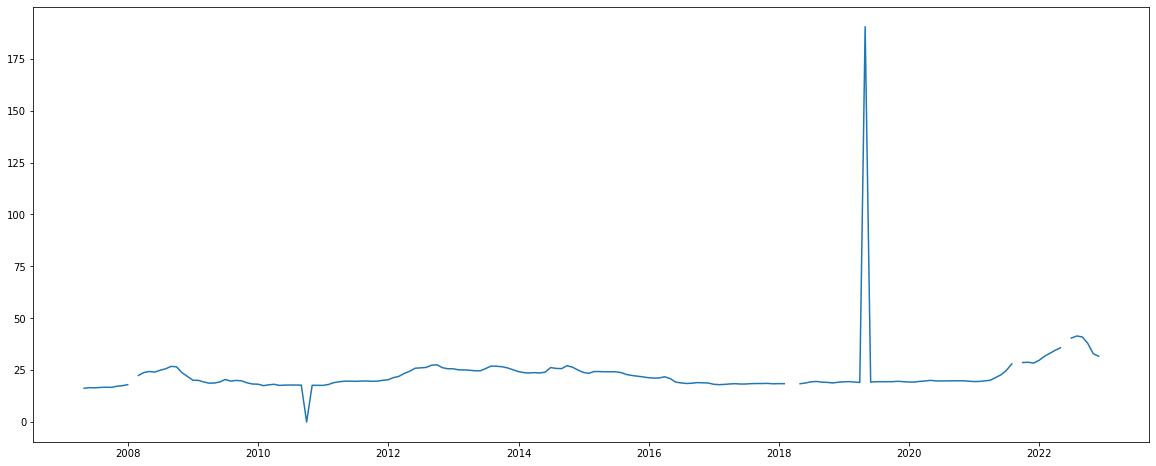

In [6]:
fig = plt.figure(figsize=(20,8))
plt.plot(data_df_raw)

### C. Predict the price for the next 18 steps (months) after the last available value. You can use any algorithm you want, and even other reference datasets not provided here. However, please try to contain everything in one file/package

#### Since we have here is a time series dataset, I am going to use ARMA, ARIMA, and SARIMA models to predict the future price of the stock.  First, let's test the stability of the data.

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

In [76]:
df = data_df_raw.dropna()
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

#so it is stationary since the p-value is smaller than alpha(0.05).
#we can directly use ARMA model

ADF Statistic: -12.249354960965059
n_lags: 9.619238769050395e-23
p-value: 9.619238769050395e-23
Critial Values:
   1%, -3.466398230774071
Critial Values:
   5%, -2.8773796387256514
Critial Values:
   10%, -2.575213838610586


#### Let's directly use Auto ARIMA to generate predictors, since then we can have the optimal p, d, and q without generating AIC, BIC and AICC

No handles with labels found to put in legend.


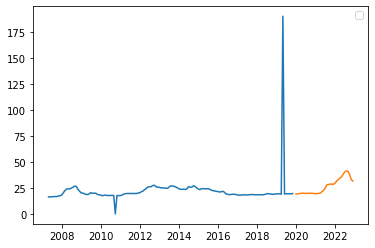

In [9]:
#In order to find the best model for price prediction, let's first split the dataset to traning and testing to check
#the models' accuracy on existing dataset
train = data_df_raw[data_df_raw.index < pd.to_datetime("2019-11-30", format='%Y-%m-%d')]
test = data_df_raw[data_df_raw.index > pd.to_datetime("2019-11-30", format='%Y-%m-%d')]
plt.plot(train)
plt.plot(test)
plt.legend()

In [10]:
# we only going to test arima with p and q from 0 to 5, also Q and P and D and d
arima_model = auto_arima(train, start_p = 0, d = 0, start_q = 0, max_p = 5, max_d = 5,
                        max_q = 5, start_P = 0, D = 0, start_Q=0, max_P = 5, max_D=5, max_Q = 5,
                        m = 12, seasonal=True, error_action = 'warn', trace = True, supress_warnings=True,
                        stepwise = True, random_state = 20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1212.207, Time=0.67 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1216.119, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1216.115, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1390.678, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1214.194, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1214.186, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1216.186, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1214.131, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1214.134, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1216.126, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.259 seconds


#### We cannot use ARIMA model since the optimal ARIMA model is ARIMA(0,0,0)(0,0,0). Let's instead try something else: LSTM

In [55]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode(connected=True)

In [58]:
train = df#use the whole dataset as training 

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

In [59]:
n_input = 18#we want to generate 18 new data
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [60]:
model = Sequential()
#Add a LSTM layer with 200 network unit
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
#a densely 1 network unit.
model.add(Dense(1))
#adam optimizer and set loss function 
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')


In [61]:
#fit the model using data
history = model.fit_generator(generator,epochs=100,verbose=1)

Epoch 1/100
28/28 [==============================] - 2s 8ms/step - loss: 0.0078
Epoch 2/100
28/28 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 3/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 4/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 5/100
28/28 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 6/100
28/28 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 7/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0057
Epoch 8/100
28/28 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 9/100
28/28 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 10/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 11/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 12/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 13/100
28/28 [=================

In [74]:
pred_list = []

batch = train[-n_input:].reshape((1, 18, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
#add new data

1/1 [==============================] - 0s 20ms/step


In [77]:
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,19) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)
#generate corresponding future date for those data

In [78]:
df = df.reset_index()
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

df_proj.tail(18)

,Date,US3387,Prediction
2022-12-30 00:00:00,NaT,NaN,33.316177
2023-01-30 00:00:00,NaT,NaN,32.437814
2023-02-28 00:00:00,NaT,NaN,31.604864
2023-03-30 00:00:00,NaT,NaN,30.837451
2023-04-30 00:00:00,NaT,NaN,30.151604
2023-05-30 00:00:00,NaT,NaN,29.555374
2023-06-30 00:00:00,NaT,NaN,29.051645
2023-07-30 00:00:00,NaT,NaN,28.642839
2023-08-30 00:00:00,NaT,NaN,28.324989
2023-09-30 00:00:00,NaT,NaN,28.090250
